In [1]:
import numpy as np 
import pandas as pd 
import plotly.express as px
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from torchvision import transforms
import torch
from torch import nn, optim

In [2]:
images = os.listdir('rtsd-frames/rtsd-frames/')
labels = pd.read_csv('df_all_pic.csv')

In [3]:
root_path = 'rtsd-frames/rtsd-frames/'

In [4]:
im = Image.open('test/autosave10_10_2012_10_18_08_1.jpg')

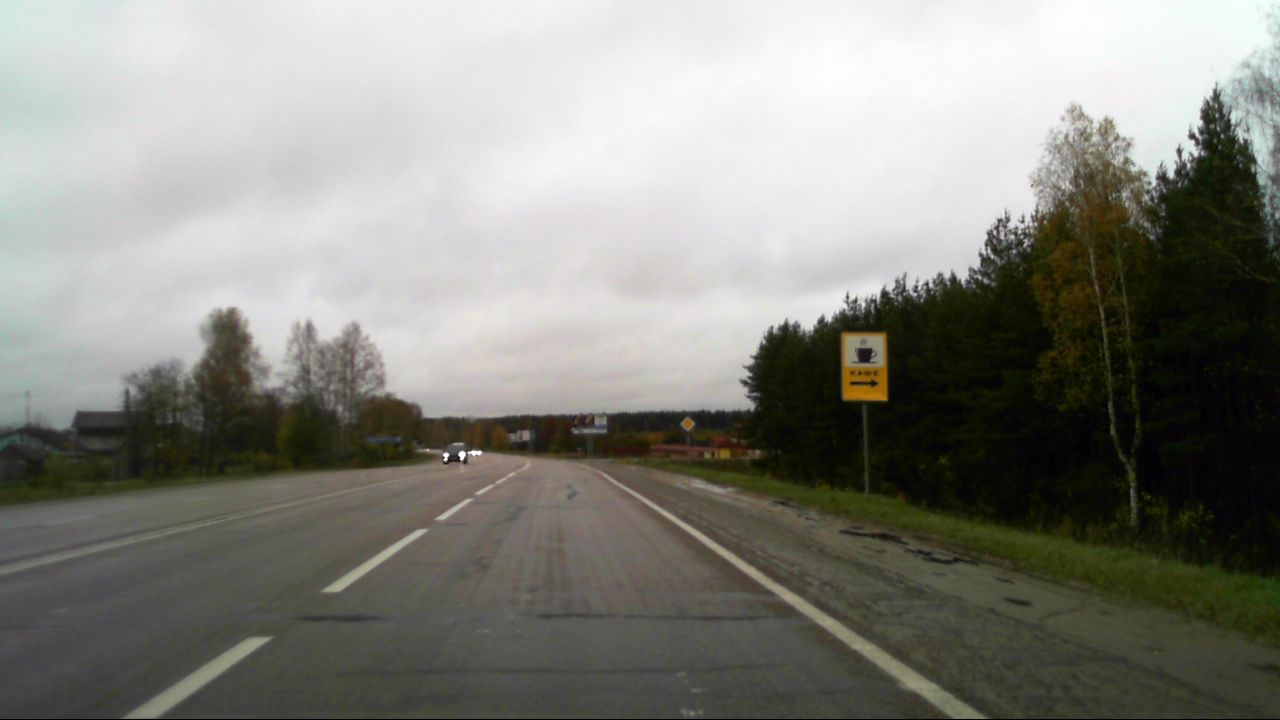

In [5]:
im

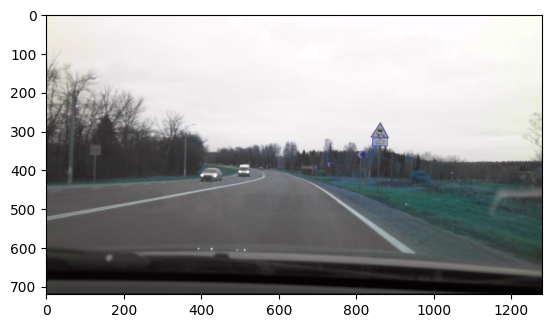

In [19]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('val/autosave23_10_2012_10_00_46_0.jpg')
dh, dw, _ = img.shape

fl = open('val/autosave23_10_2012_10_00_46_0.txt', 'r')
data = fl.readlines()
fl.close()

for dt in data:

    # Split string to float
    _, x, y, w, h = map(float, dt.split(' '))

    # Taken from https://github.com/pjreddie/darknet/blob/810d7f797bdb2f021dbe65d2524c2ff6b8ab5c8b/src/image.c#L283-L291
    # via https://stackoverflow.com/questions/44544471/how-to-get-the-coordinates-of-the-bounding-box-in-yolo-object-detection#comment102178409_44592380
    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)
    
    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)

plt.imshow(img)
plt.show()

In [ ]:
make_marking(labels.loc[labels.sign_class=='5_19_1'].index[20])

In [95]:
make_marking(labels.loc[labels.sign_class=='3_27'].index[20])

In [97]:
def make_marking_rects(indices, columns):
    rows = 198 // columns
    fig, axs = plt.subplots(rows, columns, figsize=(25, 25))
    fig.subplots_adjust(hspace=0.7)
    
    for i, idx in enumerate(indices):
        row, col = divmod(i, columns)
        ax = axs[row, col]
        
        im_labels = labels.iloc[idx]
        im = Image.open(root_path + im_labels.filename)
        
        x_min, y_min = im_labels.x_from, im_labels.y_from
        x_max, y_max = x_min + im_labels.width, y_min + im_labels.height

        ax.imshow(im)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.axis('off')
    
    plt.show()

In [98]:
unique_classes = labels['sign_class'].unique()
selected_indices = []

for class_value in unique_classes:
    class_indices = labels[labels['sign_class'] == class_value].index
    random_index = np.random.choice(class_indices, size=1, replace=False)
    selected_indices.append(int(random_index))

In [99]:
make_marking_rects(selected_indices, columns=6)

In [100]:
make_marking(selected_indices[66])

In [101]:
make_marking(selected_indices[68])

## Классификатор ResNet

In [2]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.auto import tqdm
import torch
import torchvision.models as models
import torch.nn as nn
from sklearn.metrics import classification_report
from torch.nn import functional as F

Так как в качестве sign_class у нас представлена строка, необходимо ее преобразовать в какое-то числовое значение. Для этого было сделано сопоставление к каждой уникальной строке уникального числа. Так как уникальных строк 198, то и уникальных значений class получилось 198. Сопоставление реализованы как словарь.

In [62]:
class_mapping = {class_name: class_id for class_id, class_name in enumerate(labels['sign_class'].unique())}
labels['class'] = labels['sign_class'].map(class_mapping)

In [67]:
labels['class'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154])

In [27]:
x_train, x_test, y_train, y_test = train_test_split(labels[['filename','x_from', 'y_from', 'width', 'height']], labels['class'], random_state=42)

In [28]:
class CustomDataset(Dataset):
    def __init__(self, data, targets, root_path, transform=None):
        self.data = data
        self.targets = targets
        self.root_path = root_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
   
        x = self.data.iloc[index]
        y = self.targets.iloc[index]

        # Загрузка изображения и вырезание участка
        image_path = self.root_path + x['filename']
        
        image = Image.open(image_path)
        cropped_image = image.crop((x['x_from'], x['y_from'], x['x_from'] + x['width'], x['y_from'] + x['height']))
        
        if self.transform:
            cropped_image = self.transform(cropped_image)

        return cropped_image, y


In [29]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Размер, который ожидает ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация для ResNet
])

# Создание Dataset и DataLoader для тренировочных данных

train_dataset = CustomDataset(data=x_train, targets=y_train, root_path=root_path, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Аналогично для тестовых данных
test_dataset = CustomDataset(data=x_test, targets=y_test, root_path=root_path, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [3]:
from ultralytics import YOLO
 
# Load the model.
model = YOLO('yolov8s.pt')

In [4]:
results = model.train(
   data='custom_data.yaml',
   imgsz=1280,
   epochs=60,
   batch=16,
   name='yolov8n_custom')

New https://pypi.org/project/ultralytics/8.0.216 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.212 🚀 Python-3.10.12 torch-1.12.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3090, 24260MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=custom_data.yaml, epochs=60, patience=50, batch=16, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_custom10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_

train: Scanning /home/stas/workspace/courses/itmo_courses/dl_in_practice/train.cache... 47350 images, 0 backgrounds, 33721 corrIOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)


val: Scanning /home/stas/workspace/courses/itmo_courses/dl_in_practice/val.cache... 5918 images, 0 backgrounds, 4244 corrupt: 1

val: WARNING ⚠️ /home/stas/workspace/courses/itmo_courses/dl_in_practice/val/autosave01_02_2012_09_13_48.jpg: ignoring corrupt image/label: could not convert string to float: '3_24_n20'
val: WARNING ⚠️ /home/stas/workspace/courses/itmo_courses/dl_in_practice/val/autosave01_02_2012_09_16_49.jpg: ignoring corrupt image/label: Label class 715 exceeds dataset class count 198. Possible class labels are 0-197
val: WARNING ⚠️ /home/stas/workspace/courses/itmo_courses/dl_in_practice/val/autosave01_02_2012_09_17_05.jpg: ignoring corrupt image/label: Label class 5191 exceeds dataset class count 198. Possible class labels are 0-197
val: WARNING ⚠️ /home/stas/workspace/courses/itmo_courses/dl_in_practice/val/autosave01_02_2012_09_18_44.jpg: ignoring corrupt image/label: Label class 416 exceeds dataset class count 198. Possible class labels are 0-197
val: WARNING ⚠️ /home/stas/workspace/courses/itmo_courses/dl_in_practice/val/autosave01_02_2012_09_18_48.jpg: ignoring corrupt image/label: Label clas

Plotting labels to runs/detect/yolov8n_custom10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 8 dataloader workers
Logging results to runs/detect/yolov8n_custom10
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      18.3G      1.279      7.122      1.037         21       1280: 100%|██████████| 852/852 [04:46<00:00,  2.98it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.704      0.185      0.248       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      17.7G       1.22      1.758      1.007         21       1280: 100%|██████████| 852/852 [04:40<00:00,  3.03it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.566      0.392      0.442      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      17.7G      1.257      1.479      1.023         17       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.503      0.418      0.435      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      17.7G      1.262      1.377      1.031         24       1280: 100%|██████████| 852/852 [04:37<00:00,  3.07it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.557      0.454      0.478       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      17.7G      1.224      1.232      1.021         26       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.612      0.526      0.559      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      17.7G      1.192      1.138      1.009         29       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.624      0.584      0.584      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      17.7G       1.16      1.072      1.003         25       1280: 100%|██████████| 852/852 [04:37<00:00,  3.07it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.716      0.597      0.652      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      17.7G      1.144      1.028     0.9988         26       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.725      0.632      0.688      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      17.7G      1.123     0.9864     0.9919         19       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.708      0.638      0.736      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      17.7G      1.103      0.947     0.9878         26       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.745      0.677      0.744      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      17.7G      1.094     0.9382     0.9833         21       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.749       0.68      0.784      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      17.7G      1.077     0.8937      0.978         25       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.773      0.702      0.787       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      17.7G      1.081     0.8891     0.9777         21       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.772      0.721      0.785       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      17.7G      1.062     0.8627     0.9729         21       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.746      0.746       0.81      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      17.7G      1.052     0.8446     0.9676         24       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.789      0.712      0.803      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      17.7G      1.045     0.8323      0.967         21       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.824       0.74      0.807        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      17.7G      1.041     0.8148     0.9658         17       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.826      0.725      0.811      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      17.7G      1.031     0.8001     0.9604         33       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.821      0.759       0.84      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      17.7G      1.025     0.7811     0.9587         23       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.809       0.77      0.835       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      17.7G      1.015     0.7785     0.9558         23       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.796      0.763      0.833      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      17.7G      1.011      0.761      0.952         21       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.846      0.772      0.839      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      17.7G          1     0.7471     0.9532         18       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.842      0.763      0.836      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      17.7G     0.9958     0.7404     0.9534         23       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.878      0.764      0.834      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      17.7G     0.9969     0.7273     0.9484         28       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.875      0.775      0.862      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      17.7G     0.9819     0.7146     0.9465         24       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.854      0.805      0.857      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      17.7G     0.9867     0.7129     0.9477         18       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.856       0.79      0.847       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      17.7G     0.9713     0.6998     0.9441         28       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.866      0.805      0.863      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      17.7G     0.9699     0.6919     0.9418         20       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.889      0.791      0.859      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      17.7G     0.9598     0.6791     0.9408         30       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.838      0.817       0.88      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      17.7G     0.9475     0.6684     0.9354         27       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.878      0.807       0.88      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      17.7G     0.9548     0.6692     0.9383         15       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.887      0.796      0.864      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      17.7G     0.9424     0.6577     0.9348         18       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.832      0.835      0.871      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      17.7G     0.9337     0.6473     0.9319         21       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674        0.9      0.781       0.88      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      17.7G     0.9233     0.6341     0.9275         24       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.897       0.79      0.855      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      17.7G     0.9293     0.6278     0.9318         18       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.894       0.79      0.863      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      17.7G     0.9158     0.6179      0.925         24       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.867      0.833      0.865      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      17.7G     0.9094     0.6115     0.9229         20       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.873      0.833      0.887      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      17.7G     0.8972      0.602     0.9223         22       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.888      0.828      0.867      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      17.7G     0.8891      0.589     0.9177         22       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.864      0.838      0.866      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      17.7G     0.8879     0.5832     0.9187         22       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674       0.91      0.801       0.87      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      17.7G     0.8855     0.5841     0.9193         14       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.869      0.855      0.867      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      17.7G     0.8713     0.5714     0.9142         19       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.818      0.858      0.866       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      17.7G     0.8657     0.5586     0.9103         24       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.911      0.797      0.868       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      17.7G      0.861     0.5532     0.9074         21       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674       0.91      0.799      0.875      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      17.7G     0.8538     0.5423     0.9058         27       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.911      0.788      0.876      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      17.7G     0.8438     0.5365      0.903         21       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.835      0.862      0.872      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      17.7G     0.8412     0.5291      0.902         30       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.896      0.831      0.876      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      17.7G     0.8344     0.5242     0.9016         25       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674       0.87       0.84      0.874      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      17.7G     0.8277     0.5177     0.8974         35       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.864      0.835      0.872      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      17.7G     0.8167     0.5139     0.9003         19       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.903      0.827      0.873      0.686


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      17.7G     0.8161     0.4876     0.9051         13       1280: 100%|██████████| 852/852 [04:39<00:00,  3.05it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674        0.9       0.83      0.881      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      17.7G     0.8031     0.4753     0.9013         13       1280: 100%|██████████| 852/852 [04:38<00:00,  3.05it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.899      0.834      0.877      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      17.7G     0.7925      0.464      0.896         13       1280: 100%|██████████| 852/852 [04:38<00:00,  3.05it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 


                   all       1674       1674      0.902      0.833      0.881      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      17.7G     0.7806     0.4557     0.8945         13       1280: 100%|██████████| 852/852 [04:39<00:00,  3.05it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.915      0.828       0.88      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      17.7G     0.7785     0.4516     0.8901         12       1280: 100%|██████████| 852/852 [04:38<00:00,  3.05it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.893      0.833      0.874      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      17.7G      0.768     0.4438     0.8881         13       1280: 100%|██████████| 852/852 [04:39<00:00,  3.05it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.879      0.836      0.873      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      17.7G     0.7578     0.4374     0.8883         13       1280: 100%|██████████| 852/852 [04:39<00:00,  3.05it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.932      0.793      0.872      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      17.7G     0.7493     0.4294     0.8812         12       1280: 100%|██████████| 852/852 [04:38<00:00,  3.05it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.933      0.793      0.874      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      17.7G     0.7398      0.422     0.8815         12       1280: 100%|██████████| 852/852 [04:39<00:00,  3.05it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.931      0.791      0.872      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      17.7G     0.7286      0.416     0.8786         11       1280: 100%|██████████| 852/852 [04:38<00:00,  3.06it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 

                   all       1674       1674      0.927      0.795      0.872      0.681



60 epochs completed in 4.815 hours.
Optimizer stripped from runs/detect/yolov8n_custom10/weights/last.pt, 22.7MB
Optimizer stripped from runs/detect/yolov8n_custom10/weights/best.pt, 22.7MB

Validating runs/detect/yolov8n_custom10/weights/best.pt...
Ultralytics YOLOv8.0.212 🚀 Python-3.10.12 torch-1.12.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3090, 24260MiB)
Model summary (fused): 168 layers, 11202210 parameters, 0 gradients, 28.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:09<00:00, 


                   all       1674       1674        0.9       0.83      0.881      0.694
                  7_15       1674         14          1      0.774      0.995      0.816
                   2_2       1674         23      0.967      0.696      0.771      0.639
                 4_2_1       1674          6      0.846          1      0.995      0.788
                1_20_3       1674          1          1          0      0.497      0.448
                  1_25       1674          1      0.848          1      0.995      0.895
                3_4_n8       1674         19      0.948      0.964      0.993      0.778
                 4_1_6       1674        549      0.964      0.811      0.837      0.659
                 4_2_3       1674          9      0.913      0.778      0.802       0.66
                 4_1_1       1674         20          1      0.842      0.899      0.718
                  1_33       1674        182      0.934      0.802      0.833       0.63
                5_15_

In [5]:
!pwd

/home/stas/workspace/courses/itmo_courses/dl_in_practice


In [14]:
! yolo task=detect mode=predict model=runs/detect/yolov8n_custom5/weights/best.pt source=test_image.jpg show=True imgsz=1280 name=yolov8n_custom5 hide_labels=False

zsh:1: command not found: yolo


In [12]:
model('val/autosave10_10_2012_10_27_17_1.jpg')


image 1/1 /home/stas/workspace/courses/itmo_courses/dl_in_practice/val/autosave10_10_2012_10_27_17_1.jpg: 736x1280 (no detections), 11.1ms
Speed: 4.5ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: '2_1', 1: '1_23', 2: '1_17', 3: '3_24_n40', 4: '8_2_1', 5: '5_20', 6: '3_24_n20', 7: '5_19_1', 8: '5_16', 9: '3_25_n20', 10: '6_16', 11: '7_15', 12: '2_2', 13: '2_4', 14: '8_13_1', 15: '4_2_1', 16: '1_20_3', 17: '1_25', 18: '3_4_n8', 19: '8_3_2', 20: '3_4_1', 21: '4_1_6', 22: '4_2_3', 23: '4_1_1', 24: '1_33', 25: '5_15_5', 26: '3_27', 27: '1_15', 28: '4_1_2_1', 29: '6_3_1', 30: '8_1_1', 31: '6_7', 32: '5_15_3', 33: '7_3', 34: '1_19', 35: '6_4', 36: '8_1_4', 37: '8_8', 38: '1_16', 39: '1_11_1', 40: '6_6', 41: '5_15_1', 42: '7_2', 43: '5_15_2', 44: '7_12', 45: '3_18', 46: '5_6', 47: '5_5', 48: '7_4', 49: '4_1_2', 50: '8_2_2', 51: '7_11', 52: '3_24_n5', 53: '1_22', 54: '1_27', 55: '2_3_2', 56: '5_15_2_2', 57: '1_8', 58: '3_13_r5', 59: '2_3', 60: '8_3_3', 61: '2_3_3', 62: '7_7', 63: '1_11', 64: '8_13', 65: '3_24_n30', 66: '1_12_2', 67: '1_2

In [104]:
def convert_to_yolo_format(x_from, y_from, width, height, image_width, image_height):
    # Координаты центра объекта
    x_center = (x_from + width / 2) / image_width
    y_center = (y_from + height / 2) / image_height

    # Относительные размеры объекта
    width_relative = width / image_width
    height_relative = height / image_height

    return x_center, y_center, width_relative, height_relative

# Пример использования
x_from = 649
y_from = 376
width = 18
height = 18
image_width = 1280  # Реальные размеры вашего изображения
image_height = 720  # Реальные размеры вашего изображения

yolo_format = convert_to_yolo_format(x_from, y_from, width, height, image_width, image_height)
print("YOLO формат:", yolo_format)

YOLO формат: (0.5140625, 0.5347222222222222, 0.0140625, 0.025)


In [105]:
import csv

def convert_to_yolo_format(x_from, y_from, width, height, image_width, image_height):
    # Координаты центра объекта
    x_center = (x_from + width / 2) / image_width
    y_center = (y_from + height / 2) / image_height

    # Относительные размеры объекта
    width_relative = width / image_width
    height_relative = height / image_height

    return x_center, y_center, width_relative, height_relative

def process_csv_and_write_to_txt(csv_file_path, output_folder, image_width, image_height):
    with open(csv_file_path, 'r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            filename = row['filename']
            x_from = float(row['x_from'])
            y_from = float(row['y_from'])
            width = float(row['width'])
            height = float(row['height'])
            sign_class = row['sign_class']

            # Преобразование координат в формат YOLO
            x_center, y_center, width_relative, height_relative = convert_to_yolo_format(
                x_from, y_from, width, height, image_width, image_height
            )

            # Создание текстового файла
            txt_filename = filename.replace('.jpg', '.txt')
            txt_filepath = f"{output_folder}/{txt_filename}"

            # Запись в текстовый файл
            with open(txt_filepath, 'w') as txt_file:
                txt_file.write(f"{sign_class} {x_center} {y_center} {width_relative} {height_relative}")

# Пример использования
csv_file_path = 'df_all_pic.csv'

output_folder = 'rtsd-frames/rtsd-frames/'
image_width = 1280
image_height = 720

process_csv_and_write_to_txt(csv_file_path,  output_folder, image_width, image_height)


In [106]:
import os
import random
import shutil

def split_dataset(source_folder, train_folder, val_folder, test_folder, split_ratio=(0.8, 0.1, 0.1)):
    files = [f for f in os.listdir(source_folder) if f.endswith('.jpg')]
    random.shuffle(files)

    total_files = len(files)
    train_count = int(total_files * split_ratio[0])
    val_count = int(total_files * split_ratio[1])

    train_files = files[:train_count]
    val_files = files[train_count:(train_count + val_count)]
    test_files = files[(train_count + val_count):]

    move_files(train_files, source_folder, train_folder)
    move_files(val_files, source_folder, val_folder)
    move_files(test_files, source_folder, test_folder)

def move_files(files, source_folder, destination_folder):
    for file in files:
        shutil.move(os.path.join(source_folder, file), destination_folder)
        txt_file = file.replace('.jpg', '.txt')
        shutil.move(os.path.join(source_folder, txt_file), destination_folder)

# Укажите пути к папкам
source_folder = 'rtsd-frames/rtsd-frames/'
train_folder = 'train'
val_folder = 'val'
test_folder = 'test'

# Создайте папки, если они не существуют
for folder in [train_folder, val_folder, test_folder]:
    os.makedirs(folder, exist_ok=True)

# Разделение файлов
split_dataset(source_folder, train_folder, val_folder, test_folder)
